In [26]:
from sympy import *
init_printing()

In [27]:
R = Symbol("R", positive=True, real=True)
a, b = symbols("a b", real=True)
v = (a+b)/2
i = (a-b)/(2*R)

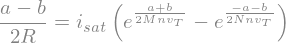

In [28]:
diode_expr = lambda isat, n, vt: lambda v: isat*(exp(v/(n*vt))-1)

def diode_eq(isat, n, vt, M, N):
    id = diode_expr(isat, n, vt)
    return lambda i, v: Eq(i, id(v/M) - id(-v/N))

isat, n, vt = symbols("i_sat n v_T", real=True, positive=True)
M, N = symbols("M N", integer=True, positive=True)
eq = diode_eq(isat, n, vt, M, N)(i, v).simplify()
eq

In [29]:
from attr import dataclass


@dataclass(frozen=True)
class NewtonRhapson:
    x: Symbol
    y: Symbol
    iteration: Expr
    jacobian: Expr
    inv_jacobian: Expr

    @classmethod
    def from_expr(cls, expr: Expr, x: Symbol, y: Symbol) -> "NewtonRhapson":
        j = diff(expr, y)
        j_inv = 1/j
        return cls(x, y, expr.simplify(), j.simplify(), j_inv.simplify())

    @classmethod
    def from_equality(cls, eq: Eq, x: Symbol, y: Symbol) -> "NewtonRhapson":
        return cls.from_expr(eq.rhs - eq.lhs, x, y)

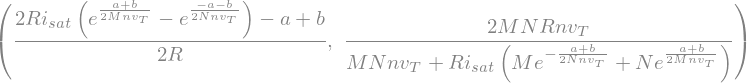

In [30]:
nr = NewtonRhapson.from_equality(eq, a, b)
nr.iteration, nr.inv_jacobian

In [31]:
def print_code(expr: Expr):
    vars, e = cse(expr.n())
    for name, expr in vars:
        yield rust_code(expr, name)
    yield rust_code(e)

print(*print_code(nr.iteration), sep="\n")

x0 = a + b;
x1 = (1_f64/2.0)/(n*v_T);
[0.5*(2.0*R*i_sat*((x0*x1/M).exp() - (-x0*x1/N).exp()) - a + b)/R]


In [32]:
print(*print_code(nr.inv_jacobian), sep="\n")

x0 = M*N*n*v_T;
x1 = (1_f64/2.0)*(a + b)/(n*v_T);
[2.0*R*x0/(R*i_sat*(M*(-x1/N).exp() + N*(x1/M).exp()) + x0)]


In [33]:
from dataclasses import dataclass, field as dfield
from itertools import repeat
from typing import Callable, TypeAlias

import numpy as np

arr: TypeAlias = np.ndarray[tuple[int], np.dtype[np.float32]]
RootEqu: TypeAlias = Callable[[arr, arr], arr]

@dataclass
class NewtonRhapson:
    """Implementation of the Newton-Rhapson method.
    Resolution is done by iterating up to n times, or when the step modifies the guess
    by less than `tol` RMS."""

    eval: RootEqu
    diff: RootEqu
    n: int = 0
    tol: float = 1e-6
    iter: list[arr] = dfield(default_factory=list)

    def __call__(self, x: arr, initial:arr|None=None) -> arr:
        """Evaluate the implicit equation at x, with the initial solution provided (default: 0)."""
        if initial is None:
            initial = np.zeros_like(x)
        guess=np.copy(initial)
        self.iter = []
        it = range(self.n) if self.n > 0 else repeat(0)
        for _ in it:
            dy = self.diff(x, guess)
            if rms(dy) < self.tol:
                break
            step = self.eval(x,guess) / dy
            srms = rms(step)
            if srms < self.tol:
                break
            # tqdm.write(f"{i:3}: {db(srms):2.3} dB RMS")
            guess -= step
            self.iter.append(np.copy(guess))
        # print(f"guessed within {db(srms)} dB")
        return guess


class NRSymbolic(NewtonRhapson):
    """Implementation of the Newton-Rhapson method over a symbolic SymPy expression.
    Resolution is done by iterating up to n times, or when the step modifies the guess
    by less than `tol` RMS."""
    def __init__(self, x: Symbol, y: Symbol, expr: Expr|Eq, *args, **kwargs):
        if isinstance(expr, Eq):
            expr = expr.rhs - expr.lhs
        self.expr = expr
        self.diff = diff(self.expr, y)
        super().__init__(lambdify([x,y], self.expr, 'scipy'), lambdify([x,y], self.diff, 'scipy'), *args, **kwargs)


def rms(x: arr) -> float:
    return np.sqrt(np.sum(x**2)/len(x))


def db(x: float) -> float:
    return 20 * np.log10(x)


def rmsdb(x: arr) -> float:
    return db(rms(x))

@dataclass(frozen=True, unsafe_hash=True)
class DiodeClipperConfiguration:
    isat: float
    n: float
    vt: float
    nf: int
    nb: int

    @classmethod
    def silicon(cls, nf: int = 1, nb: int = 1, vt: float = 23e-3) -> "DiodeClipperConfiguration":
        return cls(isat=4.352e-9, n=1.906, vt=vt, nf=nf, nb=nb)

    @classmethod
    def germanium(cls, nf: int = 1, nb: int = 1, vt: float = 23e-3) -> "DiodeClipperConfiguration":
        return cls(isat=200e-9, n=2.109, vt=vt, nf=nf, nb=nb)

    @classmethod
    def led(cls, nf: int = 1, nb: int = 1, vt: float = 23e-3) -> "DiodeClipperConfiguration":
        return cls(isat=2.96406e-12, n=2.475312, vt=vt, nf=nf, nb=nb)

    def get_equation(self, v, i):
        return diode_eq(self.isat, self.n, self.vt, self.nf, self.nb)(v, i)

    def get_nr_model(self, port_resistance, *args, **kwargs):
        a, b = symbols("a b")
        v = (a+b)/2
        i = (a-b)/(2*port_resistance)
        return NRSymbolic(a, b, self.get_equation(i, v), *args, **kwargs)

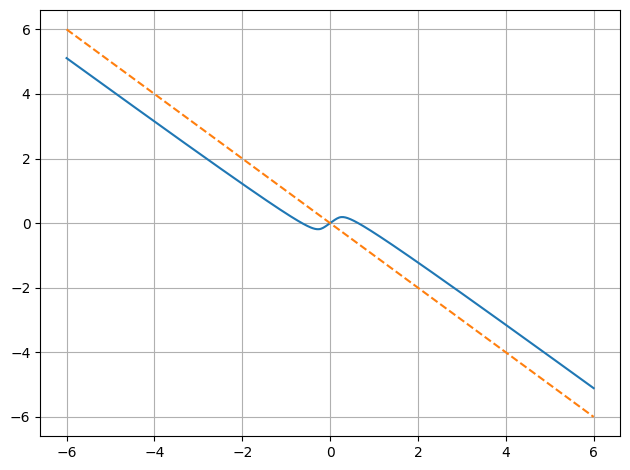

In [44]:
from matplotlib import pyplot as plt


nr = DiodeClipperConfiguration.silicon().get_nr_model(49935.994196740328, n=1000)
a = np.linspace(-6, 6, 500)
b = nr(a, initial=-a)

plt.plot(a, b)
plt.plot(a, -a, '--')
plt.grid(which="both")
plt.tight_layout()

In [41]:
nr(np.array([-61.588203921355905]))

C:\Users\solarliner\AppData\Local\Temp\ipykernel_23712\2872935038.py:57: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.sum(x**2)/len(x))


array([8.7676])